# Assignment-3 RNN (LSTM-Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


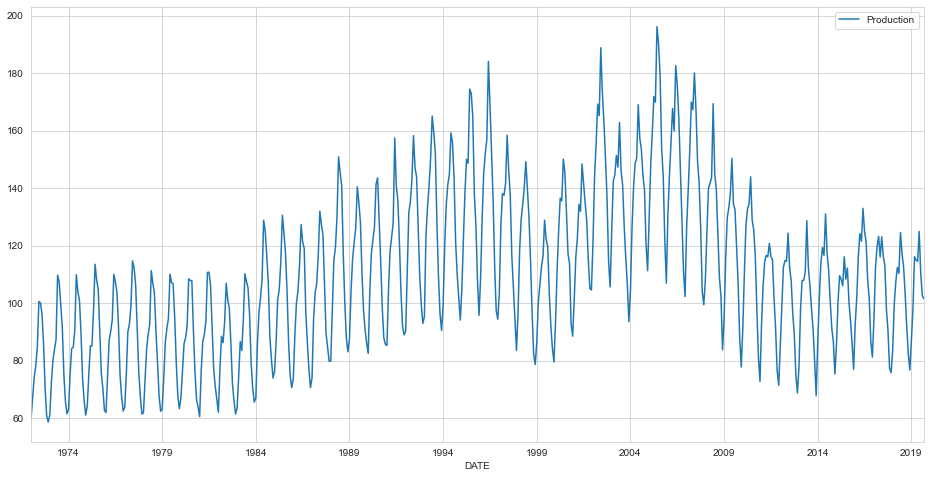

In [7]:
df.plot(figsize=(16,8));

## Preprocessing of Data

### Train Test Split

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# help(TimeseriesGenerator)

In [16]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [17]:
X, y = generator[0]

In [18]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
n_features = 1

### with "tanh" activation function

In [21]:
model1 = Sequential()
model1.add(LSTM(150, activation = 'tanh', input_shape = (length, n_features)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss = 'mse')

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [23]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

In [24]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [25]:
model1.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 4s 5ms/step - loss: 0.0236 - val_loss: 0.0016
Epoch 2/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 3/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 4/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/20
543/543 [==============================] - 2s 5ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 6/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0019


<AxesSubplot:>

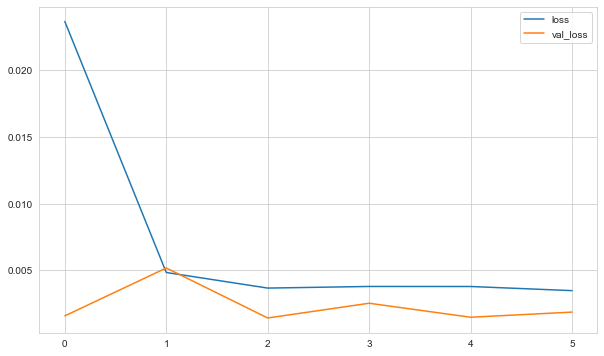

In [26]:
loss_df = pd.DataFrame(model1.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [27]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model1.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

In [30]:
test

,Production,Predictions
DATE,,
2018-04-01,112.431,114.158
2018-05-01,110.354,118.778
2018-06-01,124.584,120.129
2018-07-01,117.222,116.459
2018-08-01,112.678,108.064
2018-09-01,103.312,96.150
2018-10-01,92.132,85.372
2018-11-01,82.435,79.464
2018-12-01,76.761,80.791


<AxesSubplot:xlabel='DATE'>

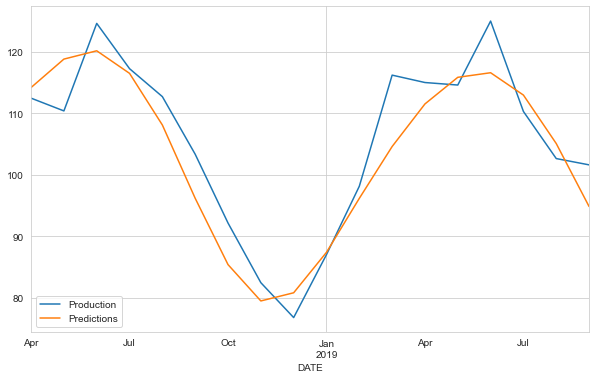

In [31]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [34]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.8412675670216545 
mae: 4.437102980034718 
mse: 28.865055458514128 
rmse: 5.372620911483903


### with "relu" activation function

In [35]:
model2 = Sequential()
model2.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [36]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [37]:
model2.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 3s 4ms/step - loss: 0.0238 - val_loss: 0.0017
Epoch 2/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 3/20
543/543 [==============================] - 2s 3ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 4/20
543/543 [==============================] - 2s 3ms/step - loss: 0.0049 - val_loss: 0.0187


<AxesSubplot:>

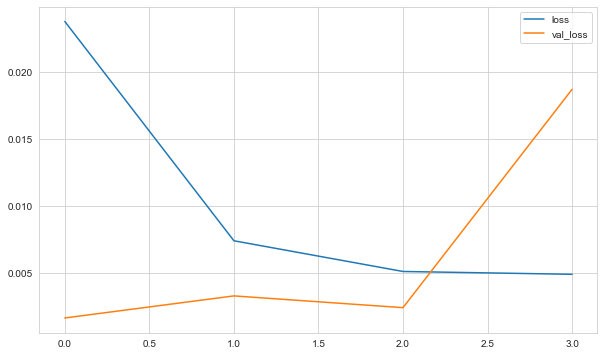

In [38]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [39]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model2.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [40]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
test['Predictions'] = true_predictions

In [42]:
test

,Production,Predictions
DATE,,
2018-04-01,112.431,129.868
2018-05-01,110.354,138.326
2018-06-01,124.584,143.207
2018-07-01,117.222,143.064
2018-08-01,112.678,137.020
2018-09-01,103.312,126.225
2018-10-01,92.132,115.595
2018-11-01,82.435,105.515
2018-12-01,76.761,103.907


<AxesSubplot:xlabel='DATE'>

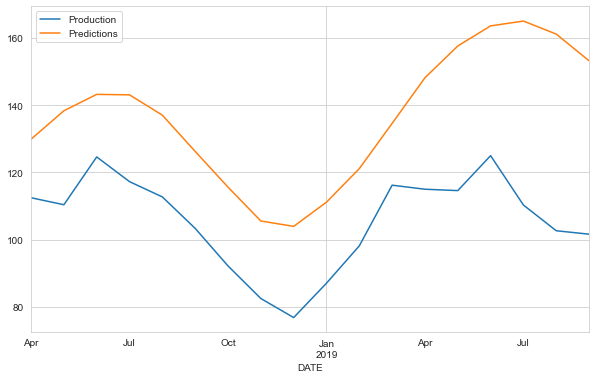

In [43]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [44]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [45]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: -5.118659767770768 
mae: 30.897102244227295 
mse: 1112.66141527974 
rmse: 33.35657978989662


## Retrain and Forecasting

In [46]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [47]:
length = 18 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [48]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8
555/555 [==============================] - 3s 4ms/step - loss: 0.0264
Epoch 2/8
555/555 [==============================] - 2s 4ms/step - loss: 0.0085
Epoch 3/8
555/555 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 4/8
555/555 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 5/8
555/555 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 6/8
555/555 [==============================] - 2s 4ms/step - loss: 0.0031
Epoch 7/8
555/555 [==============================] - 2s 4ms/step - loss: 0.0033
Epoch 8/8
555/555 [==============================] - 2s 4ms/step - loss: 0.0033


In [49]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [50]:
forecast = scaler.inverse_transform(forecast)

In [51]:
forecast

array([[ 85.31910451],
       [ 76.35237435],
       [ 76.73166587],
       [ 88.08981164],
       [ 99.77070559],
       [107.59204504],
       [112.8383004 ],
       [115.60599327],
       [114.80969829],
       [110.07077965],
       [100.92033388],
       [ 88.60254779]])

In [52]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [53]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [54]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [55]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [56]:
forecast_df

,Forecast
2019-10-01,85.319
2019-11-01,76.352
2019-12-01,76.732
2020-01-01,88.090
2020-02-01,99.771
2020-03-01,107.592
2020-04-01,112.838
2020-05-01,115.606
2020-06-01,114.810
2020-07-01,110.071


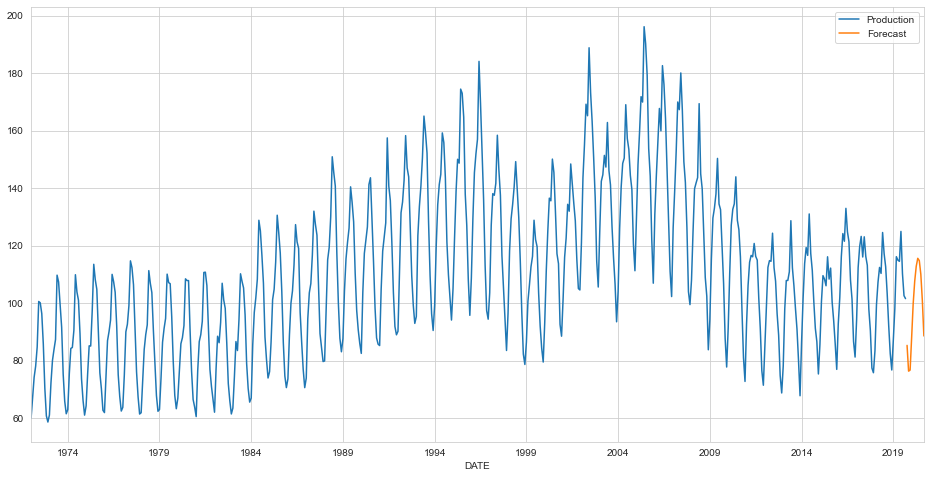

In [57]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 608.0)

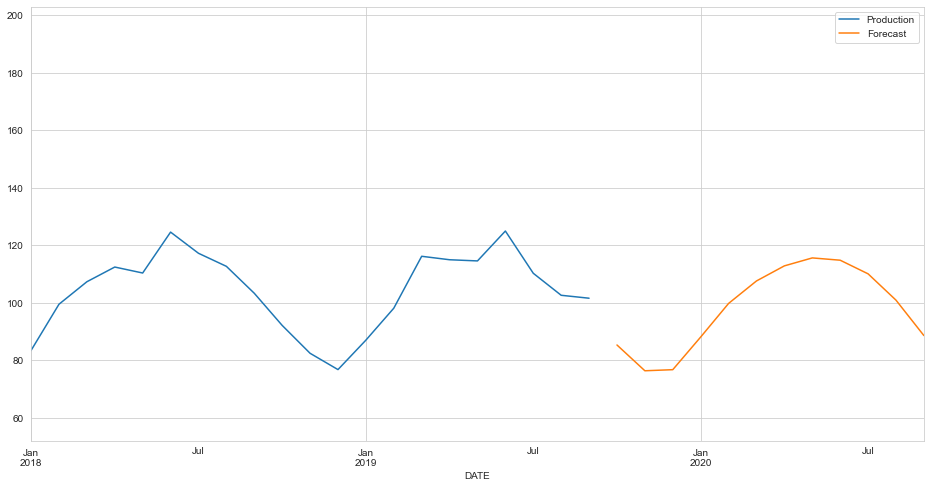

In [58]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-09-01')